### Compare performance of local vs global models

In [1]:
import os
import random
import sys
import scipy
import seaborn as sns
import matplotlib as mpl
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
import random
import torch
from cyclops.processors.column_names import EVENT_NAME
from cyclops.utils.file import load_pickle
from models.temporal.optimizer import Optimizer, EarlyStopper
from models.temporal.pytorch.utils import (
    get_data,
    get_device,
    get_temporal_model,
    load_checkpoint,
)
from models.temporal.metrics import print_metrics_binary
from drift_detection.gemini.utils import prep, get_use_case_params, import_dataset_hospital
from drift_detection.drift_detector.plotter import plot_pretty_confusion_matrix
from drift_detection.gemini.constants import DIAGNOSIS_DICT, HOSPITALS
import glob

sns.set(color_codes=True)

## Input parameters

In [2]:
DATASET = "gemini"
USE_CASE = "mortality"
DIR=os.path.join("/mnt/nfs/project/delirium/drift_exp/OCT-18-2022/",DATASET,USE_CASE,"saved_models")

use_case_params = get_use_case_params(DATASET, USE_CASE)

## Get model

In [3]:
seed = 1
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

output_dim = 1
batch_size = 64
input_dim = 91
timesteps = 6
hidden_dim = 64
layer_dim = 2
dropout = 0.2
learning_rate = 2e-3
weight_decay = 1e-6
last_timestep_only = False
model_name="lstm"
device = get_device()

model_params = {
    "device": device,
    "input_dim": input_dim,
    "hidden_dim": hidden_dim,
    "layer_dim": layer_dim,
    "output_dim": output_dim,
    "dropout_prob": dropout,
    "last_timestep_only": last_timestep_only,
}

## Get performance across all hospitals for a specified model

In [4]:
SPLIT="random"
retrain=True
ablation=False
freeze=False
N_EPOCHS=1
other = ["all_hospital"]#,"hosp_type_community","hosp_type_academic"]

for hospital_file_id in other:
    val = list()
    test = list()

    if ablation:
        hospital_file_id = hospital_file_id + "_ablation"

    if hospital_file_id in other:
        file=os.path.join(DIR,SPLIT+'_reweight_positive_lstm.pt')
    else:
        file=os.path.join(DIR,hospital_file_id+"_"+SPLIT+'_reweight_positive_lstm.pt')

    for hospital in HOSPITALS:
        torch.manual_seed(0)
        random.seed(0)    
        ID = hospital+"_random"

        (X_train, y_train), (X_val, y_val), (X_test, y_test) = import_dataset_hospital(use_case_params.TAB_VEC_COMB, ID)

        train_dataset = get_data(X_train, y_train)
        train_loader = train_dataset.to_loader(batch_size, shuffle=True)

        val_dataset = get_data(X_val, y_val)
        val_loader = val_dataset.to_loader(batch_size)

        test_dataset = get_data(X_test, y_test)
        test_loader = test_dataset.to_loader(batch_size=1, shuffle=True)

        model = get_temporal_model(model_name, model_params).to(device)
        model, opt, n_epochs = load_checkpoint(os.path.join(DIR,file), model)
        
        if freeze:
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            model.lstm.requires_grad_(False)
            trainable_params_frozen = sum(p.numel() for p in model.parameters() if p.requires_grad)
            opt.model = model
            assert trainable_params > trainable_params_frozen
            

        if retrain:
            opt.train(
                train_loader,
                val_loader,
                n_epochs=N_EPOCHS,
            )

        y_val_labels, y_val_pred_values, y_val_pred_labels = opt.evaluate(
            val_loader
        )

        y_val_pred_values = y_val_pred_values[y_val_labels != -1]
        y_val_pred_labels = y_val_pred_labels[y_val_labels != -1]
        y_val_labels = y_val_labels[y_val_labels != -1]

        val_pred_metrics = print_metrics_binary(y_val_labels, y_val_pred_values, y_val_pred_labels, verbose=False)

        y_test_labels, y_pred_values, y_pred_labels = opt.evaluate(
            test_loader
        )

        y_pred_values = y_pred_values[y_test_labels != -1]
        y_pred_labels = y_pred_labels[y_test_labels != -1]
        y_test_labels = y_test_labels[y_test_labels != -1]

        test_pred_metrics = print_metrics_binary(y_test_labels, y_pred_values, y_pred_labels, verbose=False)

        val.append(val_pred_metrics)
        test.append(test_pred_metrics)

    results_file_id = USE_CASE+'_'+hospital_file_id +'_lstm_finetune_'+str(N_EPOCHS)+'epoch'

    val = output = {
        k: [d[k] for d in val if k in d]
        for k in set().union(*val)
    }
    val_df = pd.DataFrame(val, index=HOSPITALS).sort_index()
    val_filepath = os.path.join(os.getcwd(),'../output/'+results_file_id+'_val_results.txt')
    val_df.to_csv(val_filepath, sep='\t')

    test = output = {
        k: [d[k] for d in test if k in d]
        for k in set().union(*test)
    }
    test_df = pd.DataFrame(test, index=HOSPITALS).sort_index()    
    test_filepath = os.path.join(os.getcwd(),'../output/'+results_file_id+'_test_results.txt')
    test_df.to_csv(test_filepath, sep='\t')

2023-02-01 16:30:40,599 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_SMH_random.pkl
2023-02-01 16:30:40,653 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_SMH_random.pkl
2023-02-01 16:30:40,662 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_SMH_random.pkl
2023-02-01 16:30:40,677 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_SMH_random.pkl
2023-02-01 16:30:40,681 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_SMH_random.pkl
2023-02-01 16:30:40,697 INFO cyclops.utils.fi

[1/1] Training loss: 1.0754	                 Validation loss: 1.0740


2023-02-01 16:30:48,273 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_MSH_random.pkl
2023-02-01 16:30:52,432 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_MSH_random.pkl
2023-02-01 16:30:52,579 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_MSH_random.pkl
2023-02-01 16:30:53,848 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_MSH_random.pkl
2023-02-01 16:30:53,946 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_MSH_random.pkl
2023-02-01 16:30:55,450 INFO cyclops.utils.fi

[1/1] Training loss: 1.3822	                 Validation loss: 1.5041


2023-02-01 16:30:59,745 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_THPC_random.pkl
2023-02-01 16:31:03,355 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_THPC_random.pkl
2023-02-01 16:31:03,475 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_THPC_random.pkl
2023-02-01 16:31:04,562 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_THPC_random.pkl
2023-02-01 16:31:04,646 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_THPC_random.pkl
2023-02-01 16:31:05,875 INFO cyclops.uti

[1/1] Training loss: 1.0566	                 Validation loss: 0.9644


2023-02-01 16:31:09,653 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_THPM_random.pkl
2023-02-01 16:31:15,398 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_THPM_random.pkl
2023-02-01 16:31:15,710 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_THPM_random.pkl
2023-02-01 16:31:17,219 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_THPM_random.pkl
2023-02-01 16:31:17,285 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_THPM_random.pkl
2023-02-01 16:31:19,278 INFO cyclops.uti

[1/1] Training loss: 1.3517	                 Validation loss: 1.2051


2023-02-01 16:31:25,390 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_UHNTG_random.pkl
2023-02-01 16:31:26,738 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_UHNTG_random.pkl
2023-02-01 16:31:26,908 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_UHNTG_random.pkl
2023-02-01 16:31:28,571 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_UHNTG_random.pkl
2023-02-01 16:31:28,640 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_UHNTG_random.pkl
2023-02-01 16:31:31,010 INFO cyclop

[1/1] Training loss: 1.3087	                 Validation loss: 1.4020


2023-02-01 16:31:35,299 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_UHNTW_random.pkl
2023-02-01 16:31:36,972 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_UHNTW_random.pkl
2023-02-01 16:31:37,466 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_UHNTW_random.pkl
2023-02-01 16:31:39,743 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_UHNTW_random.pkl
2023-02-01 16:31:39,849 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_UHNTW_random.pkl
2023-02-01 16:31:41,331 INFO cyclop

[1/1] Training loss: 1.2856	                 Validation loss: 1.3238


2023-02-01 16:31:44,872 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_X_SBK_random.pkl
2023-02-01 16:31:51,473 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_train_y_SBK_random.pkl
2023-02-01 16:31:51,716 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_X_SBK_random.pkl
2023-02-01 16:31:53,791 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_val_y_SBK_random.pkl
2023-02-01 16:31:53,922 INFO cyclops.utils.file - Loading pickled data from /mnt/nfs/project/delirium/drift_exp/OCT-18-2022/gemini/mortality/./data/4-final/aligned_comb_test_X_SBK_random.pkl
2023-02-01 16:31:56,345 INFO cyclops.utils.fi

[1/1] Training loss: 1.1176	                 Validation loss: 1.1274


In [5]:
test_df

,auroc,minpse,rec0,prec0,auprc,rec1,acc,prec1
MSH,0.849454,0.447679,0.614480,0.979764,0.421038,0.882769,0.640689,0.198654
SBK,0.825072,0.317020,0.605170,0.985559,0.290286,0.879474,0.623968,0.140802
SMH,0.857902,0.329545,0.628023,0.989654,0.314686,0.899491,0.644668,0.136407
THPC,0.845181,0.339515,0.603367,0.989362,0.279700,0.894286,0.620188,0.121553
THPM,0.853003,0.383047,0.603118,0.986167,0.370324,0.914700,0.631232,0.186054
UHNTG,0.836603,0.392857,0.608849,0.979854,0.380641,0.861611,0.629816,0.166149
UHNTW,0.841375,0.353360,0.569810,0.987683,0.298363,0.924335,0.600246,0.167905


## Gather results for all models

In [6]:
results=[]
files=glob.glob(os.path.join(os.getcwd(),'../output',USE_CASE,USE_CASE+'_'+'*_test_results.txt'))
for file in files:
    model_id = '_'.join(os.path.basename(file).split('_')[1:-2])
    if 'specific' not in model_id:
        test_df = pd.read_csv(file, sep='\t')
        test_df.columns.values[0] = 'Evaluated Hospital'
        test_df['Model'] = model_id
        test_df.index = test_df['Model']
        results.append(test_df)
results = pd.concat(results)
auroc_heatmap = results[['auroc','Evaluated Hospital','Model']].pivot("Model","Evaluated Hospital")
#auroc_heatmap['avg auroc'] = auroc_heatmap['auroc'].mean(axis=1)

auprc_heatmap = results[['auprc','Evaluated Hospital','Model']].pivot("Model","Evaluated Hospital")
#auprc_heatmap['avg auprc'] = auprc_heatmap['auprc'].mean(axis=1)
auprc_heatmap.columns = auprc_heatmap.columns.droplevel()


## Heatmap + Clustering

/tmp/ipykernel_938846/2821806637.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_heatmap.set_yticklabels(auroc_heatmap.iloc[xind,yind].columns.get_level_values(1)[::-1])


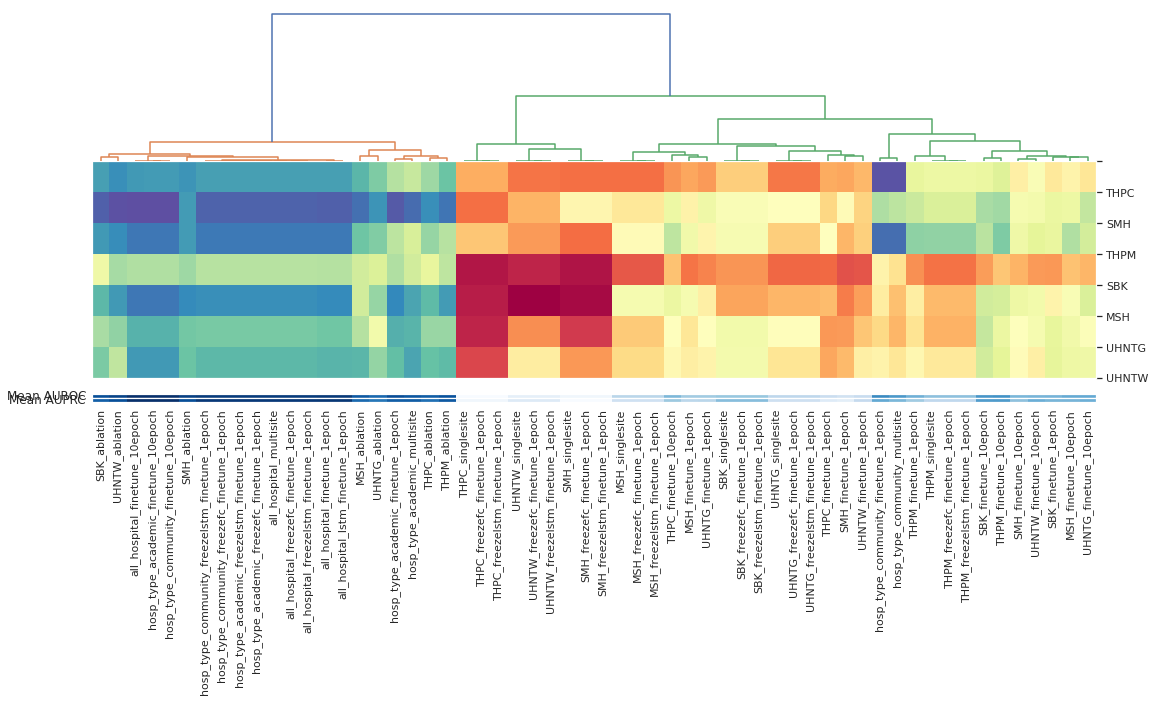

In [7]:
# HAC clustering (compute linkage matrices)
method = 'ward'
N_rows = auroc_heatmap.shape[0]
N_cols = auroc_heatmap.shape[1]
hospital_links = scipy.cluster.hierarchy.linkage(auroc_heatmap.to_numpy(), method=method, metric='euclidean')
method_links = scipy.cluster.hierarchy.linkage(auroc_heatmap.to_numpy().transpose(), method=method, metric='euclidean')

fig = plt.figure(figsize=(18,12))

gs0 = gs.GridSpec(2,1, figure=fig,height_ratios=[7,5], hspace=0.05)
gs1 = gs.GridSpecFromSubplotSpec(2,1, subplot_spec=gs0[0],
                                                  height_ratios=[5,7],
                                                  hspace=0)

ax_heatmap = fig.add_subplot(gs1[1])
ax_col_dendrogram = fig.add_subplot(gs1[0], sharex=ax_heatmap)

col_dendrogram = scipy.cluster.hierarchy.dendrogram(hospital_links, ax=ax_col_dendrogram)
row_dendrogram = scipy.cluster.hierarchy.dendrogram(method_links, no_plot=True)
ax_col_dendrogram.set_axis_off()

xind = col_dendrogram['leaves']
yind = row_dendrogram['leaves']

avg_auroc = pd.DataFrame(auroc_heatmap.mean(axis=1),columns=['AUROC']).values.flatten()
avg_auprc = pd.DataFrame(auprc_heatmap.mean(axis=1),columns=['AUPRC']).values.flatten()
xmin,xmax = ax_col_dendrogram.get_xlim()
img = ax_heatmap.imshow(auroc_heatmap.iloc[xind,yind].T, aspect='auto', extent=[xmin,xmax,0,7], cmap='Spectral') 
ax_heatmap.set_yticks([], minor=True)
ax_heatmap.set_yticklabels(auroc_heatmap.iloc[xind,yind].columns.get_level_values(1)[::-1])
ax_heatmap.yaxis.tick_right()
ax_heatmap.grid(False)
plt.setp(ax_heatmap.get_xticklabels(), visible=False)
#plt.colorbar(img, ax=ax_heatmap,location='left', shrink=0.6)
gs2 = gs.GridSpecFromSubplotSpec(N_rows, 1, subplot_spec=gs0[1])

for i,(data,label) in enumerate(zip([avg_auroc,avg_auprc],
                                    ['Mean AUROC','Mean AUPRC'])):
    ax = fig.add_subplot(gs2[i], sharex=ax_heatmap)
    img2 = ax.imshow(np.vstack([data[xind],data[xind]]), extent=[xmin,xmax,0,7], cmap='Blues',)
    ax.set_aspect('auto')
    ax.set_yticks([])
    ax.set_ylabel(label, rotation=0, labelpad=45, va='center')
    ax.set_xticklabels(auroc_heatmap.iloc[xind,yind].index)
    ax.tick_params(axis='x', which='major', pad=0)
    ax.grid(False)
    plt.xticks(rotation=90)
    if label != 'Mean AUPRC':
        plt.setp(ax.get_xticklabels(), visible=False)


In [8]:
auroc_heatmap.idxmax()

       Evaluated Hospital
auroc  MSH                         all_hospital_finetune_10epoch
       SBK                                          SMH_ablation
       SMH                   hosp_type_academic_finetune_10epoch
       THPC                  hosp_type_community_finetune_1epoch
       THPM                  hosp_type_community_finetune_1epoch
       UHNTG                  hosp_type_academic_finetune_1epoch
       UHNTW                 hosp_type_academic_finetune_10epoch
dtype: object

In [9]:
results['id'] = results['Model'].str.split('_',expand=True).loc[:,1:].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)
results['id'] = results['id'].str.replace('_None','')
results['id'] = results['id'].str.replace('hospital_','')

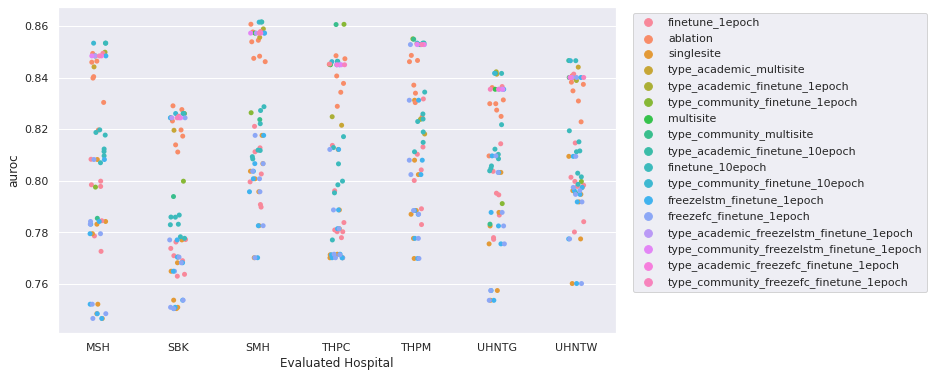

In [101]:
results_max = results.groupby('Evaluated Hospital').agg({'auroc':['max','idxmax'], 'auprc':['max','idxmax']})
results_max.columns = pd.MultiIndex.from_tuples(
    [('AUROC',    'Max'),
    ('AUROC', 'Model'),
    ('AUPRC',    'Max'),
    ('AUPRC', 'Model')],
)
fig = sns.stripplot(data=results,  x="Evaluated Hospital", y="auroc", hue="id")
fig.figure.set_size_inches(10, 6)
plt.legend(bbox_to_anchor=(1.02, 1), loc=2)